In [130]:
import bz2
import lzma
import pickle
import json
import os.path
import sys
import time

from imageio import imread
import numpy as np
import matplotlib.pyplot as plt

import numba as nb
nb_u1 = nb.types.uint8
nb_u2 = nb.types.uint16

import pymongo

sys.path.append(r'C:\Users\hornu\OneDrive\Documents\repos\flags\scripts\image-scripts')
from image_scaler_cleaner import ImageScalerCleaner

A concise document based database is created in which textual, numeric and image data are stored.


## Motivation




## Database design


### Preliminary data structure

The current database, `flags` 

In [2]:
mg_client = pymongo.MongoClient("mongodb://localhost:27017/")
print(mg_client.list_database_names())

['admin', 'config', 'flags', 'local']


consists of a single collection, `raw_countries`:

In [3]:
db_flag = mg_client["flags"]
print(db_flag.list_collection_names())

['raw_countries']


in which each document lists the attributes of a particular country:

In [4]:
cl_flag = db_flag["raw_countries"]
cl_flag.find_one({})

{'_id': ObjectId('5cadf3ff351ab01d60a664b2'),
 'adapted': 2004,
 'path': 'C:\\Users\\hornu\\OneDrive\\Documents\\repos\\flags\\data\\clean-data\\images\\afghanistan.png',
 'code': 'AF',
 'religion': 'ISLAM',
 'continent': 'ASIA',
 'founded': 9999,
 'independent': '1823',
 'neighbours': ['CN', 'IR', 'PK', 'TJ', 'TM', 'UZ'],
 'name': 'AFGHANISTAN'}

The fields are either pertaining to the country herself:

* `name` : name of the country
* `code` : two-letter iso code of the country
* `founded` : year in which her or her ancestor was founded. 9999 stands for missing data
* `independent` : year in which the country became independent
* `religion` : predominant religion in the country
* `continent` : continent on which the major landmass of the country situated
* `neighbours` : the two letter iso codes of its neighbours

or to its flag:
* `adapted` : year in which the current flag was introduced
* `path` : path to the `png` image of the flag in local store

### Design goals

We wish to store these pieces of information in a more orderly fashion. The fields relevant to the country should be contained in a document separated from those relevant to the flag itself. Two collections will thus be created 

* `countries` and
* `flags`

#### Country document

A country document will have three main fields
* `_id` : unique id
* `code` : two-letter iso code of the country
* `data` : all other fields
    * `name` : name of the country
    * `founded` :  year in which her or her ancestor was founded
    * ...
    
The country codes of the `neighbours` list will be replaced by the respective `_id`-s. This implies, the collection must be built in two passes.

#### Flag document

The flags are stored in a different collection. The schema of a document is the following

* `_id` : unique id
* `code` : two letter country code
* `data` : information on the flag
    * `adapted` : year in which the current flag was introduced
    * `colours` : a dictionary in which the flag's constituent colours are listed along with their weights
    * `dimensions` : a dictionary of height and width
    * `canvas` : the flag itself
    

## Implementation

We set out to implement all the transformations that are required to create the new database.

### Flags

The main issue is to find an efficient format for storing the canvas of the flag. We went at [great length](https://bhornung.github.io/python/2019/04/09/flags-1.html) to rig the flag of spurious colours, therefore any lossy compression is out of question. 

#### Copressing the flag

The cleaned image is a 3D `uint8` numpy array.  Let us assume an average flag has $500 \cot 1000$ pixels. Each pixel consists of three meaningful channels (R, G, B). It is then represented in the memory as an array of of size $500 \cdot 1000 \cdot 3 = 1.5 \cdot 10^{6}$ This corresponds to 1.5MBs per image. We wish to make our objects as small as possible so that they travel through the network and memory quickly.

There are multiple paths to achieve this:
* `numpy` array $\rightarrow$ pickled object $\rightarrow$ `bzip`-ed object $\rightarrow$ Binary field in mongodb
* `numpy` array $\rightarrow$ compressed/modified `numpy` array $\rightarrow$ pickled object $\rightarrow$ Binary field in `mongodb`
* `numpy` array $\rightarrow$ compressed/modified `numpy` array $\rightarrow$ pickled object $\rightarrow$ `bzip`-ed object $\rightarrow$ Binary field in `mongodb`

In the first route the pickled array is compressed. These images compress really well, for there are many similar byte sequences corresponding to identical colours. The drawback is that the image has to be manipulated by `bz2` which can be slow.

Following he second path one modifies the numpy array to an other one of considerably smaller size whilst retaining all the spatial information. This array is then pickled. In this case the unpickled object can be used by numpy straight away.

The third one might be overkill. 

In [32]:
@nb.jit(nopython = True)
def compress_image(X):
    
    ir, jr, _ = X.shape
    coo = []
    
    for i in range(ir):
        
        for j in range(0, jr - 1):
            
            # append end of color region and colour
            if X[i, j, 0] != X[i, j+1, 0] or \
               X[i, j, 1] != X[i, j+1, 1] or \
               X[i, j, 2] != X[i, j+1, 2] :
                
                coo.append([i, j + 1, X[i, j, 0], X[i, j, 1], X[i, j, 2]])
        
        # last colour in a row
        coo.append([i, j + 2, X[i, -1, 0], X[i, -1, 1], X[i, -1, 2]])      
          
    # convert to np.ndarray
    compressed = np.array(coo, dtype = np.uint16)
    
    return compressed

In [101]:
@nb.jit(nopython = True)
def decompress_images(X):
    
    h = np.int64(X[-1, 0] + 1)
    v = np.int64(X[-1, 1])
    
    decompressed = np.zeros((h, v, 3), dtype = np.uint16)
     
    i_old = -1
    j_old = 0
    
    for k in range(X.shape[0]):
        
        i = X[k,0]
        j = X[k,1] 
        c1 = X[k,2] 
        c2 = X[k,3]
        c3 = X[k,4]
        
        if i != i_old:
            j_old = 0
        
        decompressed[i, j_old : j, 0] = c1
        decompressed[i, j_old : j, 1] = c2
        decompressed[i, j_old : j, 2] = c3
        i_old, j_old = i, j

    return decompressed

In [297]:
@nb.jit(nopython = True)
def compress_image2(X):
    
    ir, jr, _ = X.shape
    coo = []
    
    r_s, c_s = 0, 0
    c_old = X[0, 0]
    
    for i in range(ir):
        
        for j in range(0, jr):
            
            # append end of color region and colour
            if X[i, j, 0] != c_old[0] or \
               X[i, j, 1] != c_old[1] or \
               X[i, j, 2] != c_old[2]:
                
                if j == 0:
                    coo.append([r_s, c_s, i - 1, jr, c_old[0], c_old[1], c_old[2]])
                    
                else:
                    coo.append([r_s, c_s, i, j, c_old[0], c_old[1], c_old[2]])
                    
                c_old = X[i, j]
                r_s, c_s = i, j
        
    coo.append([r_s, c_s, ir - 1, jr, c_old[0], c_old[1], c_old[2]])
          
    # convert to np.ndarray
    compressed = np.array(coo, dtype = np.uint16)
    
    return compressed

In [328]:
@nb.jit(nopython = True)
def decompress_image2(X):
    
    h = np.int64(X[-1, 2] + 1)
    v = np.int64(X[-1, 3])
    
    decompressed = np.zeros((h, v, 3), dtype = np.uint8)
    
    for k in range(X.shape[0]):
        
        r_s = X[k,0]
        c_s = X[k,1]
        r_e = X[k,2]
        c_e = X[k,3]
        
        if r_s == r_e:
            decompressed[r_s, c_s : c_e] = X[k, 4:]
            
        elif r_s + 1 == r_e:
            decompressed[r_s, c_s :] = X[k, 4:]
            decompressed[r_e, : c_e] = X[k, 4:]
            
        else:
            
            decompressed[r_s, c_s :] = X[k, 4:]
            decompressed[r_s + 1 : r_e, :] = X[k, 4:]
            decompressed[r_e, : c_e] = X[k, 4:]

    return decompressed

In [259]:
# TO SKIP -- boring

# choose specified number of random images
path_to_image_dir = r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images'
paths = np.array([os.path.join(path_to_image_dir, x) for x in os.listdir(path_to_image_dir)])

n_sel = 50
idcs_sel = np.random.choice(len(paths), n_sel, replace = False)

images = [ImageScalerCleaner().clean(imread(paths[idx])) for idx in idcs_sel]

In [257]:
# TO SKIP -- boring

ratios_1 = np.zeros(n_sel, dtype = np.float32)
times_1 = np.zeros(n_sel, dtype = np.float32)

for idx, image in enumerate(images):
    
    # times
    t_start = time.perf_counter()
    compressed_dump = lzma.compress(pickle.dumps(image))
    recon = pickle.loads(lzma.decompress(compressed_dump))
    t_end = time.perf_counter()
    
    times_1[idx] = t_end - t_start
    
    # compression ratio
    ratios_1[idx] = len(compressed_dump) / (image.size * 2) 

In [331]:
# TO SKIP -- boring

ratios_2 = np.zeros(n_sel, dtype = np.float32)
times_2 = np.zeros(n_sel, dtype = np.float32)

for idx, image in enumerate(images):
    
    # times
    t_start = time.perf_counter()
    compressed_dump = pickle.dumps(compress_image2(image))
    recon = decompress_image2(pickle.loads(compressed_dump))
    t_end = time.perf_counter()
    
    times_2[idx] = t_end - t_start
    
    # compression ratio
    ratios_2[idx] = len(compressed_dump) / (image.size * 2) 

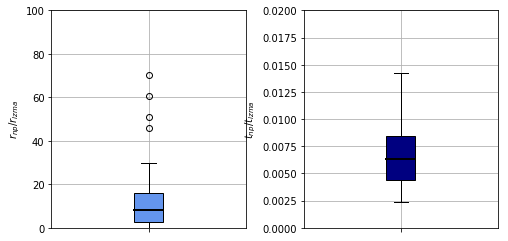

In [348]:
fig, axes = plt.subplots(1, 2, gridspec_kw = {"wspace" : 0.3})
fig.set_size_inches(8, 4)

axes[0].grid(True); axes[1].grid(True)
axes[0].set_ylim((0,100)); axes[1].set_ylim((0,0.02));
axes[0].set_ylabel(r'$r_{np} / r_{lzma}$'); axes[1].set_ylabel(r'$t_{np} / t_{lzma}$');

box_plot = axes[0].boxplot(ratios_2 /ratios_1, labels=[''], patch_artist=True, medianprops=dict(linewidth=2, color='black'))
box_plot['boxes'][0].set_facecolor('cornflowerblue')
        
box_plot = axes[1].boxplot(times_2 /times_1, labels=[''], patch_artist=True, medianprops=dict(linewidth=2, color='black'))
box_plot['boxes'][0].set_facecolor('navy')

plt.show()